## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2
from keras.layers import BatchNormalization
from keras.layers import Dropout

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_l2_ratio=1e-4, drp_ratio=0.2):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1_l2_ratio,l1_l2_ratio))(input_layer)
            x = BatchNormalization()(x)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1_l2_ratio,l1_l2_ratio))(x)
            x = BatchNormalization()(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = [128, 256]
Dropout_EXP = [0.2, 0.3]
L1_L2_EXP = [1e-4, 1e-8, 1e-12]

In [7]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for regulizer_ratio in L1_L2_EXP:
    for bn in BATCH_SIZE:
        for dropexp in Dropout_EXP:
            keras.backend.clear_session() # 把舊的 Graph 清掉
            print("Experiment with L1_L2 Regulizer = %.6f" % (regulizer_ratio))
            print("Experiment with BATCH SIZE = %.6f" % (bn))
            print("Experiment with Dropout rate = %.6f" % (dropexp))
            model = build_mlp(input_shape=x_train.shape[1:], l1_l2_ratio=regulizer_ratio,
                              drp_ratio=dropexp)
            model.summary()
            optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
            model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

            model.fit(x_train, y_train, 
                      epochs=EPOCHS, 
                      batch_size=bn, 
                      validation_data=(x_test, y_test), 
                      shuffle=True)

            # Collect results
            train_loss = model.history.history["loss"]
            valid_loss = model.history.history["val_loss"]
            train_acc = model.history.history["acc"]
            valid_acc = model.history.history["val_acc"]

            exp_name_tag = "exp-l1_l2-%s-BATCH SIZE-%s-Dropout rate-%s" % (str(regulizer_ratio), str(bn), str(dropexp))
            results[exp_name_tag] = {'train-loss': train_loss,
                                     'valid-loss': valid_loss,
                                     'train-acc': train_acc,
                                     'valid-acc': valid_acc}

W0112 15:47:18.156286  5584 deprecation_wrapper.py:119] From C:\Users\g-yongruhsiao\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0112 15:47:18.158288  5584 deprecation_wrapper.py:119] From C:\Users\g-yongruhsiao\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0112 15:47:18.196287  5584 deprecation_wrapper.py:119] From C:\Users\g-yongruhsiao\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0112 15:47:18.213289  5584 deprecation_wrapper.py:119] From C:\Users\g-yongruhsiao\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_b

Experiment with L1_L2 Regulizer = 0.000100
Experiment with BATCH SIZE = 128.000000
Experiment with Dropout rate = 0.200000


W0112 15:47:18.798785  5584 deprecation_wrapper.py:119] From C:\Users\g-yongruhsiao\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
__________

W0112 15:47:19.112785  5584 deprecation.py:323] From C:\Users\g-yongruhsiao\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 26s 513us/step - loss: 4.5701 - acc: 0.3318 - val_loss: 3.4334 - val_acc: 0.2913
Epoch 2/50
50000/50000 [==============================] - 26s 519us/step - loss: 2.8743 - acc: 0.3740 - val_loss: 3.2843 - val_acc: 0.1877
Epoch 3/50
50000/50000 [==============================] - 24s 477us/step - loss: 2.5774 - acc: 0.3895 - val_loss: 2.9625 - val_acc: 0.2152
Epoch 4/50
50000/50000 [==============================] - 22s 438us/step - loss: 2.4399 - acc: 0.3988 - val_loss: 2.7200 - val_acc: 0.2754
Epoch 5/50
50000/50000 [==============================] - 21s 417us/step - loss: 2.3199 - acc: 0.4059 - val_loss: 2.5846 - val_acc: 0.2689
Epoch 6/50
50000/50000 [==============================] - 22s 447us/step - loss: 2.2273 - acc: 0.4107 - val_loss: 2.8956 - val_acc: 0.2251
Epoch 7/50
50000/50000 [==============================] - 24s 480us/step - loss: 2.1707 - acc: 0.4160 - val_loss: 2.

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 31s 613us/step - loss: 4.8439 - acc: 0.3065 - val_loss: 3.6227 - val_acc: 0.2921
Epoch 2/50
50000/50000 [==============================] - 26s 529us/step - loss: 2.9874 - acc: 0.3548 - val_loss: 3.3176 - val_acc: 0.1988
Epoch 3/50
50000/50000 [==============================] - 23s 458us/step - loss: 2.6240 - acc: 0.3686 - val_loss: 3.0916 - val_acc: 0.2564
Epoch 4/50
50000/50000 [==============================] - 22s 444us/step - loss: 2.4807 - acc: 0.3750 - val_loss: 2.6934 - val_acc: 0.2960
Epoch 5/50
50000/50000 [==============================] - 23s 456us/step - loss: 2.3945 - acc: 0.3770 - val_loss: 2.7292 - val_acc: 0.2436
Epoch 6/50
50000/50000 [==============================] - 23s 463us/step - loss: 2.2933 - acc: 0.3846 - val_loss: 2.5475 - val_acc: 0.2801
Epoch 7/50
50000/50000 [==============================] - 23s 460us/step - loss: 2.2504 - acc: 0.3835 - val_loss: 2.

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 24s 484us/step - loss: 5.1127 - acc: 0.3301 - val_loss: 4.1945 - val_acc: 0.2710
Epoch 2/50
50000/50000 [==============================] - 19s 374us/step - loss: 3.3206 - acc: 0.3926 - val_loss: 3.8182 - val_acc: 0.1698
Epoch 3/50
50000/50000 [==============================] - 18s 352us/step - loss: 2.6736 - acc: 0.4051 - val_loss: 3.1113 - val_acc: 0.2566
Epoch 4/50
50000/50000 [==============================] - 17s 343us/step - loss: 2.5369 - acc: 0.4076 - val_loss: 3.0554 - val_acc: 0.2366
Epoch 5/50
50000/50000 [==============================] - 19s 386us/step - loss: 2.4418 - acc: 0.4210 - val_loss: 3.7243 - val_acc: 0.1384
Epoch 6/50
50000/50000 [==============================] - 20s 409us/step - loss: 2.3230 - acc: 0.4296 - val_loss: 3.1809 - val_acc: 0.2050
Epoch 7/50
50000/50000 [==============================] - 19s 371us/step - loss: 2.2306 - acc: 0.4319 - val_loss: 3.

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 26s 514us/step - loss: 5.3291 - acc: 0.2966 - val_loss: 4.5983 - val_acc: 0.2078
Epoch 2/50
50000/50000 [==============================] - 23s 456us/step - loss: 3.5273 - acc: 0.3642 - val_loss: 3.2545 - val_acc: 0.2597
Epoch 3/50
50000/50000 [==============================] - 22s 431us/step - loss: 2.7874 - acc: 0.3792 - val_loss: 4.4176 - val_acc: 0.1264
Epoch 4/50
50000/50000 [==============================] - 20s 397us/step - loss: 2.5581 - acc: 0.3842 - val_loss: 3.6683 - val_acc: 0.1403
Epoch 5/50
50000/50000 [==============================] - 19s 375us/step - loss: 2.4738 - acc: 0.3925 - val_loss: 2.9779 - val_acc: 0.2288
Epoch 6/50
50000/50000 [==============================] - 19s 374us/step - loss: 2.3821 - acc: 0.4037 - val_loss: 2.6680 - val_acc: 0.2942
Epoch 7/50
50000/50000 [==============================] - 19s 376us/step - loss: 2.2734 - acc: 0.4099 - val_loss: 2.

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 41s 812us/step - loss: 1.9054 - acc: 0.3339 - val_loss: 1.8731 - val_acc: 0.3456
Epoch 2/50
50000/50000 [==============================] - 32s 641us/step - loss: 1.6711 - acc: 0.4045 - val_loss: 1.7635 - val_acc: 0.3618
Epoch 3/50
50000/50000 [==============================] - 29s 583us/step - loss: 1.5917 - acc: 0.4312 - val_loss: 1.6843 - val_acc: 0.4070
Epoch 4/50
50000/50000 [==============================] - 31s 620us/step - loss: 1.5568 - acc: 0.4423 - val_loss: 1.6247 - val_acc: 0.4185
Epoch 5/50
50000/50000 [==============================] - 28s 567us/step - loss: 1.5183 - acc: 0.4546 - val_loss: 1.7136 - val_acc: 0.3902
Epoch 6/50
50000/50000 [==============================] - 29s 584us/step - loss: 1.4874 - acc: 0.4659 - val_loss: 1.5218 - val_acc: 0.4539
Epoch 7/50
50000/50000 [==============================] - 36s 715us/step - loss: 1.4739 - acc: 0.4731 - val_loss: 1.

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 38s 752us/step - loss: 2.0139 - acc: 0.3108 - val_loss: 1.8214 - val_acc: 0.3413
Epoch 2/50
50000/50000 [==============================] - 31s 629us/step - loss: 1.7334 - acc: 0.3826 - val_loss: 2.0027 - val_acc: 0.2858
Epoch 3/50
50000/50000 [==============================] - 33s 659us/step - loss: 1.6609 - acc: 0.4040 - val_loss: 1.6483 - val_acc: 0.4075
Epoch 4/50
50000/50000 [==============================] - 32s 640us/step - loss: 1.6358 - acc: 0.4157 - val_loss: 1.6235 - val_acc: 0.4125
Epoch 5/50
50000/50000 [==============================] - 32s 639us/step - loss: 1.6071 - acc: 0.4247 - val_loss: 1.5254 - val_acc: 0.4556
Epoch 6/50
50000/50000 [==============================] - 32s 644us/step - loss: 1.5780 - acc: 0.4351 - val_loss: 1.4893 - val_acc: 0.4595
Epoch 7/50
50000/50000 [==============================] - 32s 649us/step - loss: 1.5698 - acc: 0.4391 - val_loss: 1.

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 29s 573us/step - loss: 1.9362 - acc: 0.3318 - val_loss: 1.7804 - val_acc: 0.3514
Epoch 2/50
50000/50000 [==============================] - 22s 437us/step - loss: 1.6699 - acc: 0.4060 - val_loss: 1.6893 - val_acc: 0.3951
Epoch 3/50
50000/50000 [==============================] - 21s 427us/step - loss: 1.5846 - acc: 0.4380 - val_loss: 1.6615 - val_acc: 0.4055
Epoch 4/50
50000/50000 [==============================] - 21s 422us/step - loss: 1.5261 - acc: 0.4555 - val_loss: 1.6584 - val_acc: 0.3994
Epoch 5/50
50000/50000 [==============================] - 22s 434us/step - loss: 1.4907 - acc: 0.4694 - val_loss: 1.7013 - val_acc: 0.3910
Epoch 6/50
50000/50000 [==============================] - 21s 428us/step - loss: 1.4702 - acc: 0.4757 - val_loss: 1.5468 - val_acc: 0.4428
Epoch 7/50
50000/50000 [==============================] - 22s 432us/step - loss: 1.4510 - acc: 0.4815 - val_loss: 1.

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 27s 542us/step - loss: 2.0728 - acc: 0.2986 - val_loss: 1.7583 - val_acc: 0.3721
Epoch 2/50
50000/50000 [==============================] - 20s 402us/step - loss: 1.7522 - acc: 0.3745 - val_loss: 1.7467 - val_acc: 0.3634
Epoch 3/50
50000/50000 [==============================] - 20s 406us/step - loss: 1.6652 - acc: 0.4059 - val_loss: 1.6924 - val_acc: 0.3919
Epoch 4/50
50000/50000 [==============================] - 21s 417us/step - loss: 1.6165 - acc: 0.4245 - val_loss: 1.6468 - val_acc: 0.4024
Epoch 5/50
50000/50000 [==============================] - 20s 402us/step - loss: 1.5973 - acc: 0.4325 - val_loss: 1.7141 - val_acc: 0.3803
Epoch 6/50
50000/50000 [==============================] - 21s 415us/step - loss: 1.5710 - acc: 0.4364 - val_loss: 1.6836 - val_acc: 0.3939
Epoch 7/50
50000/50000 [==============================] - 21s 421us/step - loss: 1.5587 - acc: 0.4437 - val_loss: 1.

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 40s 790us/step - loss: 1.8998 - acc: 0.3392 - val_loss: 1.7973 - val_acc: 0.3489
Epoch 2/50
50000/50000 [==============================] - 32s 645us/step - loss: 1.6620 - acc: 0.4092 - val_loss: 1.8009 - val_acc: 0.3466
Epoch 3/50
50000/50000 [==============================] - 32s 645us/step - loss: 1.5850 - acc: 0.4350 - val_loss: 1.8349 - val_acc: 0.3450
Epoch 4/50
50000/50000 [==============================] - 33s 650us/step - loss: 1.5469 - acc: 0.4454 - val_loss: 1.5637 - val_acc: 0.4478
Epoch 5/50
50000/50000 [==============================] - 32s 646us/step - loss: 1.5144 - acc: 0.4575 - val_loss: 1.4669 - val_acc: 0.4773
Epoch 6/50
50000/50000 [==============================] - 33s 665us/step - loss: 1.4942 - acc: 0.4654 - val_loss: 1.5142 - val_acc: 0.4527
Epoch 7/50
50000/50000 [==============================] - 33s 666us/step - loss: 1.4753 - acc: 0.4737 - val_loss: 1.

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 40s 803us/step - loss: 2.0127 - acc: 0.3063 - val_loss: 1.9192 - val_acc: 0.3140
Epoch 2/50
50000/50000 [==============================] - 33s 666us/step - loss: 1.7316 - acc: 0.3818 - val_loss: 1.7377 - val_acc: 0.3753
Epoch 3/50
50000/50000 [==============================] - 33s 658us/step - loss: 1.6525 - acc: 0.4104 - val_loss: 1.6213 - val_acc: 0.4161
Epoch 4/50
50000/50000 [==============================] - 33s 653us/step - loss: 1.6210 - acc: 0.4221 - val_loss: 1.6482 - val_acc: 0.3968
Epoch 5/50
50000/50000 [==============================] - 33s 663us/step - loss: 1.6050 - acc: 0.4252 - val_loss: 1.5955 - val_acc: 0.4332
Epoch 6/50
50000/50000 [==============================] - 34s 674us/step - loss: 1.5808 - acc: 0.4339 - val_loss: 1.4941 - val_acc: 0.4634
Epoch 7/50
50000/50000 [==============================] - 34s 681us/step - loss: 1.5657 - acc: 0.4398 - val_loss: 1.

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 32s 646us/step - loss: 1.9443 - acc: 0.3280 - val_loss: 1.7503 - val_acc: 0.3702
Epoch 2/50
50000/50000 [==============================] - 23s 459us/step - loss: 1.6734 - acc: 0.4055 - val_loss: 2.0273 - val_acc: 0.2965
Epoch 3/50
50000/50000 [==============================] - 23s 468us/step - loss: 1.5871 - acc: 0.4337 - val_loss: 1.8930 - val_acc: 0.3276
Epoch 4/50
50000/50000 [==============================] - 23s 460us/step - loss: 1.5419 - acc: 0.4490 - val_loss: 1.8204 - val_acc: 0.3470
Epoch 5/50
50000/50000 [==============================] - 23s 457us/step - loss: 1.5030 - acc: 0.4639 - val_loss: 1.5620 - val_acc: 0.4406
Epoch 6/50
50000/50000 [==============================] - 24s 483us/step - loss: 1.4834 - acc: 0.4689 - val_loss: 1.5444 - val_acc: 0.4421
Epoch 7/50
50000/50000 [==============================] - 24s 480us/step - loss: 1.4559 - acc: 0.4798 - val_loss: 1.

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 32s 641us/step - loss: 2.0621 - acc: 0.3006 - val_loss: 1.8375 - val_acc: 0.3506
Epoch 2/50
50000/50000 [==============================] - 24s 471us/step - loss: 1.7469 - acc: 0.3765 - val_loss: 1.7951 - val_acc: 0.3415
Epoch 3/50
50000/50000 [==============================] - 23s 455us/step - loss: 1.6729 - acc: 0.4027 - val_loss: 1.7180 - val_acc: 0.3723
Epoch 4/50
50000/50000 [==============================] - 23s 469us/step - loss: 1.6180 - acc: 0.4222 - val_loss: 1.6146 - val_acc: 0.4276
Epoch 5/50
50000/50000 [==============================] - 23s 466us/step - loss: 1.5883 - acc: 0.4301 - val_loss: 1.5741 - val_acc: 0.4406
Epoch 6/50
50000/50000 [==============================] - 23s 466us/step - loss: 1.5671 - acc: 0.4396 - val_loss: 1.6559 - val_acc: 0.4014
Epoch 7/50
50000/50000 [==============================] - 23s 460us/step - loss: 1.5558 - acc: 0.4442 - val_loss: 1.

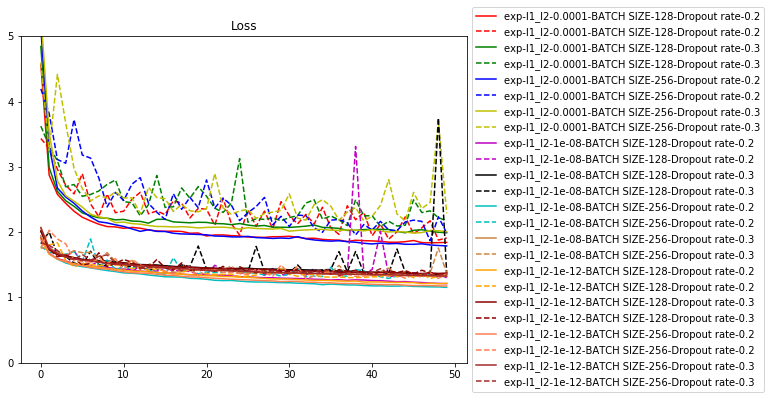

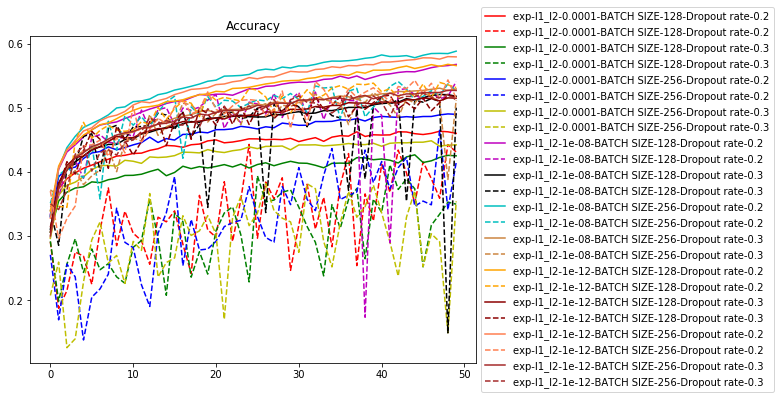

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k","c", "peru" , "orange", "darkred", "coral", "brown"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5))
plt.show()